# **ENN: Expressive Neural Network (Pytorch implementation)**

### **1. Introduction**

This notebook provides an implementation of the [Expressive Neural Network (ENN)](https://arxiv.org/abs/2307.00673) with Pytorch. Visit [ENN (Numpy version)](https://colab.research.google.com/drive/1e6Gtt2f3RU0a6bGukLi1XPDV8xw-lxDs?usp=sharing) for a low-level implementation of the model, focusing on the learning algorithm (i.e., least mean squares - LMS).

The ENN is a multilayer perceptron with adaptive activation functions (AAF). What makes the ENN expressive and interpretable is that these nonlinear AAF are modeled with the discrete cosine transform (DCT). The coefficients of the DCT are learnt during backpropagation. The ENN is the first neural network model that relies on signal processing techniques.

The notebook is divided into the following sections:
1.   Introduction.
2.   Libraries and datasets.
3.   Why use the DCT?
4.   ENN model.
5.   Performance.


### **2. Libraries and datasets**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from scipy.fftpack import dct, idct
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cpu")

In [2]:
def MSE_loss(a, b, norm=False):
    """
    This function computes the MSE between to arrays.

    Parameters
    ----------
    a, b : ndarray
        Input arrays. The first one is the reference that will be used to
        normalize the MSE.
    norm: boolean
        If True, the MSE is normalized by the power of the array a.

    Returns
    -------
    real
        The MSE between the two arrays.
    """
    MSE = ((a-b)**2).mean()
    MSE_norm = MSE/np.sum(a**2)
    return MSE_norm if norm else MSE

def truncate(v, M):
    """
    This function truncates a vector up to the M largest components. The rest
    (length(v)-M) are set to 0.

    Parameters
    ----------
    v : ndarray
        Input array.
    M : int
        Number of largest components to maintain.

    Returns
    -------
    v : ndarray
        Output array.
    M_pos : ndarray
        Indeces of non-zero kept entries.
    """
    v = v.copy()
    idx = np.argsort(-abs(v))
    v[idx[M:]] = 0
    M_pos = np.nonzero(v)[0]
    return v, M_pos

The goal of these experiments is to show the ability of the ENN to represent complex nonlinear functions in a supervised setting. For this reason, we do not work with standard machine learning datasets (e.g., MNIST), but with synthetic data. Using traditional datasets hinders the analysis due to the existence of other issues (e.g., dataset distribution). We further constrain the analysis to two input variables, which eases the interpretability of the results. Nonetheless, it does not prevent from extending the ENN to multiple input variables.

In the following we provide a wide variety of binary functions:
*   **Classification problems:** these are linear, quadratic, cubic and higher-order binary classification problems.
*   **Regression problems:** we provide the sum, norm and product.





In [3]:
class Dataset2D:
  def __init__(self, n_samples, function):
    self.n_samples = n_samples
    self.function = function
    self.x = 2*( np.random.rand(2,n_samples) -0.5*np.ones((2,n_samples)) )

    #Classification problems
    if function == 1: # Linear discriminant
        y = -np.zeros(n_samples)
        a = -0.4
        b = -0.3
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 2: # Linear discriminant
        y = -np.zeros(n_samples)
        a = 2
        b = 0.5
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 3: # Linear discriminant
        y = -np.zeros(n_samples)
        a = 1
        b = 0
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 4: # Linear discriminant
        y = -np.zeros(n_samples)
        a = 0
        b = 0
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 5: # Ring
        y = -np.zeros(n_samples)
        rad_out = 0.65
        rad_in = 0.3
        shift_in = np.array([[0,0]]).T
        pos = (np.linalg.norm(self.x, axis=0) < rad_out) & (np.linalg.norm(self.x-shift_in, axis=0) > rad_in)
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 6: # Quadratic discriminant
        y = -np.zeros(n_samples)
        a = 0.3
        b = -0.2
        c = 0.1
        pos = self.x[0,:] < a*self.x[1,:]**2 + b*self.x[1,:] + c
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 7: # Cubic discriminant
        y = -np.zeros(n_samples)
        a = -0.3
        b = 0.2
        c = 0.0
        d = 0.1
        pos = self.x[0,:] < a*(self.x[1,:]**3) + b*(self.x[1,:]**2) + c*(self.x[1,:]**2) + d
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 8: # Stripes
        y = -np.zeros(n_samples)
        pos = self.x[0,:] < 300*np.sin( 10*(self.x[1,:]+0.15) )
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 9: # Sine
        y = -np.zeros(n_samples)
        pos = self.x[0,:] < np.sqrt(0.5)*np.sin( 10*(self.x[1,:]+0.15) )
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 10: # Cirlce and ellipse
        y = -np.zeros(n_samples)
        rad_in = 0.35
        cen_1 = np.array([[0.3,0.45]]).T
        cen_2 = np.array([[-0.3,-0.4]]).T
        exce = np.array([[2,1]]).T
        pos = (np.linalg.norm((self.x-cen_1)/exce, axis=0) < rad_in) | (np.linalg.norm(self.x-cen_2, axis=0) < rad_in)
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 11: # Face
        y = -np.zeros(n_samples)
        rad_out = 0.65
        rad_in = 0.3
        shift_out = np.array([[0,-0.2]]).T
        shift_in = np.array([[0,-0.2]]).T
        cir_l = np.array([[-0.35,0.7]]).T
        cir_r = np.array([[0.35,0.7]]).T
        rad_circ = 0.2
        pos_ring = (np.linalg.norm(self.x-shift_out, axis=0) < rad_out) & (np.linalg.norm(self.x-shift_in, axis=0) > rad_in)
        pos_circ = (np.linalg.norm(self.x-cir_l, axis=0) < rad_circ) | (np.linalg.norm(self.x-cir_r, axis=0) < rad_circ)
        y[pos_ring | pos_circ] = 1
        self.y = y
        self.category = 'classification'

    #Regression problems
    elif function == 12: # Sum
        y = np.sum(self.x, axis=0)/2
        self.y = y
        self.category = 'regression'

    elif function == 13: # Norm
        y = np.linalg.norm(self.x, axis=0)**2/2
        self.y = y
        self.category = 'regression'

    elif function == 14: # Product
        y = np.prod(self.x, axis=0)
        self.y = y
        self.category = 'regression'

The following function generates a Dataset to be used by the Pytorch model.

In [6]:
class CustomDataset(Dataset2D):
    def __init__(self, n_train, function, transform=None):
        dataset = Dataset2D(n_train, function)
        self.data = dataset.x.T
        self.targets = dataset.y[...,None]
        self.category = dataset.category
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        target = self.targets[index]

        # Convert numpy array to PyTorch tensor
        sample = torch.tensor(sample, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        # Apply transformations if available
        if self.transform:
            sample = self.transform(sample)

        return sample, target

The following code shows how to create a dataset and visualize it.

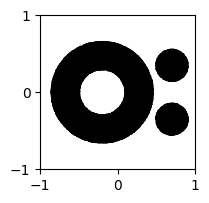

In [7]:
function = 11 # Visualize only classification functions, i.e., function in [1,11]
samples = 100000 #The more samples, the better the visualization
dataset = CustomDataset(samples, function)

fig = plt.figure( figsize=(2,2) )
plt.scatter(dataset.data[:,1], dataset.data[:,0], dataset.targets, 'k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.show()

### **3. Why use the DCT?**

Assume a set of function values $y_n$ for $n=0,\dots, N-1$.

We will use the following definition for the Discrete Cosine Transform (DCT), which corresponds to the Type-II DCT:
\begin{equation}
Y_k = f_k\sum_{n=0}^{N-1} y_n \cos\left(\frac{\pi k(2n+1)}{2N}\right)\quad \text{for} \quad k=0,\dots, N-1
\end{equation}

where $f_k=1/\sqrt N$ for $k=0$ and $f_k=\sqrt{2/N}$ otherwise. The $y_n$ are each one of the function values and $Y_k$ are termed the DCT coefficients.

Regarding the inverse DCT (iDCT), we use the definition provided by the orthonormal Type-III DCT:
\begin{equation}
y_n = \sum_{k=0}^{N-1} f_kY_k \cos\left(\frac{\pi (2n+1)k}{2N}\right)\quad \text{for} \quad n=0,\dots, N-1
\end{equation}

To understand the relationship between the discrete Fourier transform (DFT) and the DCT, we compute the three following transformations over a sigmoid function:
*   DFT of the sigmoid function.
*   DCT of the sigmoid function.
*   DFT of the sigmoid function, which has previously been extended to have even symmetry.

In fact, the last two computations are equivalent. This is, the DCT takes a function and extends it to have even symmetry. Then, the FFT is computed over this new function. As seen below, the DFT coefficients of the extended function are equivalent to the DCT coefficients. In fact, by doing so, the resolution of the DCT is doubled with respect to the DCT.

Note that the x-axis does not correspond to time, as it usually happens with Fourier transformations. In here, the x-axis is the domain of the function.

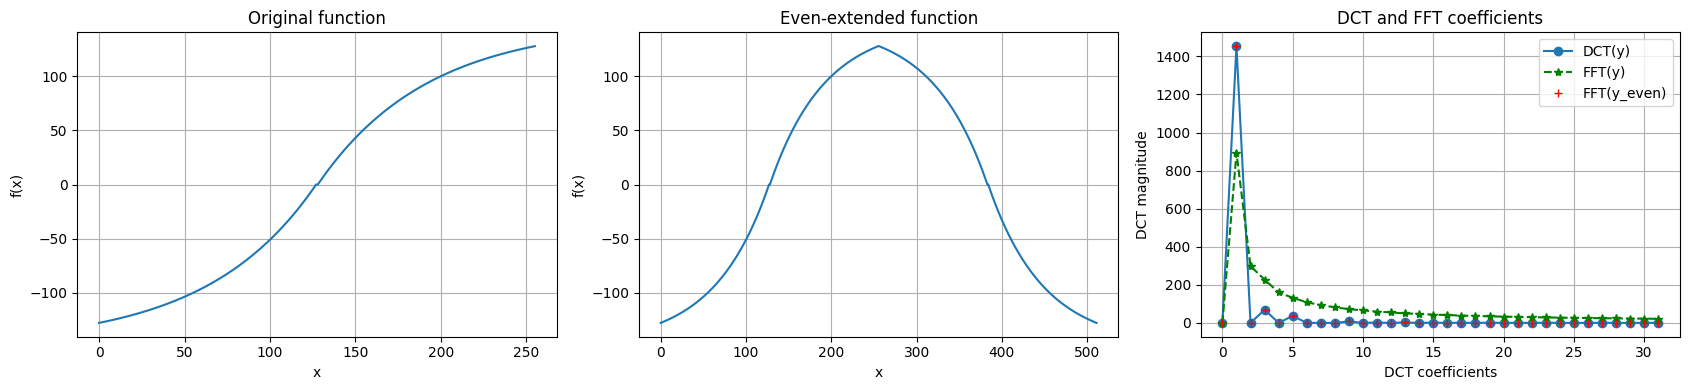

In [8]:
N = 256
x = np.arange(1, N+1)
mu = -0.5 * N/2
y_left = (N/2) * ( 1 - np.exp( -(1/mu)*x[:int(N/2)] )) / ( 1 - np.exp( -N/(2*mu) ))
y_right = np.flip(-y_left) + N
y = np.hstack(( y_left, y_right )) - N/2
y_even = np.hstack(( y, np.flip(y) ))

Y_dct = dct(y, norm='ortho')
Y_fft = np.fft.fft(y, norm='ortho')
Y_even_fft = np.fft.fft(y_even, norm='ortho')


# Plots #######################################################################
fig, ax = plt.subplots(1, 3, figsize=(17,4))
ax[0].plot(y, '-')
ax[0].set(xlabel='x', ylabel='f(x)')
ax[0].set_title('Original function')
ax[0].grid()

ax[1].plot(y_even, '-')
ax[1].set(xlabel='x', ylabel='f(x)')
ax[1].set_title('Even-extended function')
ax[1].grid()

ax[2].plot(abs(Y_dct[0:32]), 'o-')
ax[2].plot(abs(Y_fft[0:32]), 'g--*')
ax[2].plot(abs(Y_even_fft[0:32]), 'r+')
ax[2].legend(['DCT(y)', 'FFT(y)', 'FFT(y_even)'])
ax[2].set(xlabel='DCT coefficients', ylabel='DCT magnitude')
ax[2].set_title('DCT and FFT coefficients')
ax[2].grid()
fig.tight_layout()

The results are evident: the DCT achieves a large compression. In the following we show the MSE that the DCT achieves and the relationship with respect to its coefficients. This will be exemplified with a different compressor function.

The energy (in %) retained by the DCT approximation is
\begin{equation}
\alpha = \frac{\sum_{m=1}^{M}Y_m^2}{\sum_{m=1}^{N}Y_m^2},
\end{equation}
where $M$ is the number of preserved coefficients. Since the DCT basis (i.e., the cosines) are orthogonal, the preserved energy corresponds to the fraction of energy retained in the coefficients.

Furthermore, the normalized mean squared error (NMSE) that the approximation achieves with $M$ coefficients corresponds to
\begin{equation}
NMSE = \frac{1}{N}\frac{\sum_{m=M+1}^{N}Y_m^2}{\sum_{m=1}^{N}Y_m^2}=
\frac{1-\alpha}{N},
\end{equation}
which is no more the energy preserved in the disregarded coefficients.

Then, the DCT will be a good model as long as it preserves the required coefficients. Luckily, the DCT coefficients for smooth functions with odd symmetry (as the ones considered in these examples) are ordered in decreasing magnitude. Furthermore, notice that only the odd coefficients are different from zero and ordered in decreasing order. The latter happens due to the odd symmetry of the function.

This is what makes the DCT a good model for function approximation: The transformation is highly interpretable and the performance with respect to the coefficients is well defined. In practice, we will constrain the DCT model to have only odd coefficients. While this constraints the nonlinear activation function to be odd, this does not constrain the multilayer perceptron from learning non-odd functions. This assumption also eases building the model for function approximation, because the coefficients are real and ordered in decreasing order. Thus, the only hyperparameter that the ENN will need to manage with respect to the nonlinear activation function is the number of preserved coefficients, $M$. In practice we see that more than $M=6$ coefficients is not needed. Then, $M$ can be fixed from the start.




Energy retained:  0.9973546928415632
MSE_norm:  1.0333231087643195e-05 1.0333231087643769e-05


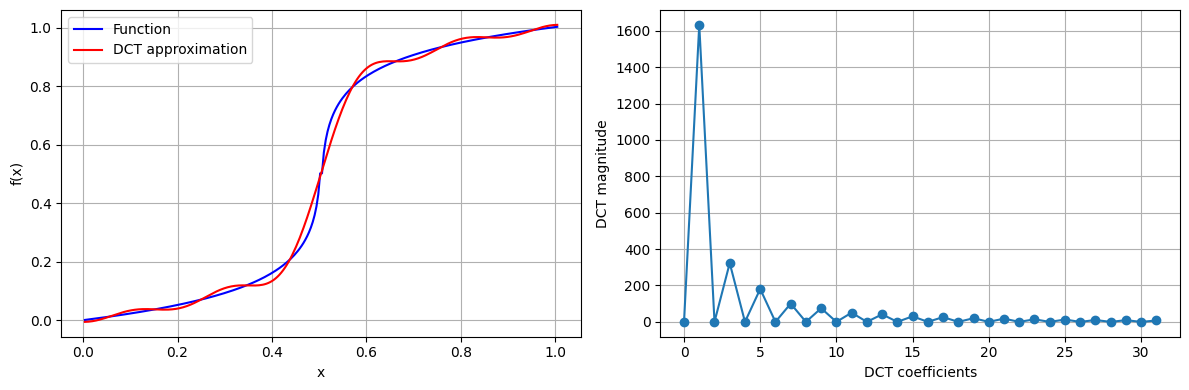

In [9]:
N = 256
x = np.arange(1,N+1)
y_right = np.log(x[:int(N/2)])
y = (N/2)/np.log(x[int(N/2)]) * np.hstack(( np.flip(-y_right), y_right ))

M = 5 #Change this parameter from 1 to 256
Y_dct = dct(y, norm='ortho')
Y_dct_trunc, M_pos = truncate(Y_dct, M)
y_aprox = idct(Y_dct_trunc, norm='ortho')

alpha = np.sum(Y_dct_trunc**2) / np.sum(Y_dct**2)
MSE = MSE_loss(y, y_aprox, norm=True)
print('Energy retained: ', alpha)
print('MSE_norm: ', MSE, (1-alpha)/N)

# Plots #######################################################################
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(x/255,  (y+128)/255, 'b')
ax[0].plot(x/255, (y_aprox+128)/255, 'r')
ax[0].set(xlabel='x', ylabel='f(x)')
ax[0].legend(['Function', 'DCT approximation'])
ax[0].grid()

ax[1].plot(abs(Y_dct[0:32]), 'o-')
ax[1].set(xlabel='DCT coefficients', ylabel='DCT magnitude')
ax[1].grid()

fig.tight_layout()

### **4. ENN model**

We construct a multilayer perceptron with 2 inputs, a single hidden layer and an output neuron. The ENN contains the following input parameters:
*   `input_dim`: number of inputs (i.e., 2).
*   `hidden_dim`: number of hidden neurons.
*   `output_dim`: number of output neurons (i.e., 1).
*   `n_coeffs`: number of DCT coefficients to represent each AAF  (in practice, no more than 6 are required).
*   `nft`: number of DCT samples to represented each AAF (fixed to 512).
*   `init`: it determines the initilization of the linear weights in the hidden and output layer. if `True`, the linear weights are initialized to provide bump diversity. If `False`, the initialization of the linear weights is the default by Pytorch (i.e., random).

Bump diversity refers to the fact that the AAF are oriented in different directions with respect to the output two-dimensional space. For instance, with `hidden_dim=2`, the linear weights in the hidden layer are initialized so that one AAF lays on the x-axis, and the other one in the y-axis. Intuitively, this speeds up convergence by providing diversity in as many different directions as possible. Check the paper for a detailed explanation on this topic.

---

The `forward()` function processes the information forwards through the ENN. We define `out_fc1` as the output of the linear weights in the hidden layer. The AAF computes the following:
$$
\text{hid_out} = \sum_{q=1}^{Q/2}F_q\cos\left(\frac{\pi(2q-1)(2\bar{x}+1)}{2\text{N}}\right),
$$

where $\bar{x}=\frac{N}{2}(\text{out_fc1}+1)$ and $N$ is the number of nft points (i.e., `nft`). Notice that the DCT coefficients (`F_hid` and `F_out`) are defined as `Parameter()` with `requires_grad=True`, to ensure that the gradient information is retrieved for the backpropagation.

---

In Section 3 we have discussed the benefits of the DCT with respect to function approximation. In general, the DCT is a model that it is much easier to interpret and tune than other function approximations. From the perspective of learning, however, the DCT provides other advantages: in backpropagation, the derivative of the cosine is a sine, which is bounded. Then, the DCT does not experience exploding gradients. Furthermore, there are closed-form expressions for the gradient, which are not feasible with other approximation models.



In [10]:
class ENN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_coeffs=6, nft=512, init=False):
        super(ENN, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        if init:
            W_hid = torch.zeros((hidden_dim,input_dim))
            gam = 0.5 # Intial dynamic range
            rad = 2*np.pi/(2*hidden_dim)
            for i in range(hidden_dim):
                W_hid[i,:] = gam * torch.tensor([np.cos(i*rad), np.sin(i*rad)])

            W_out = torch.zeros(hidden_dim)
            W_out[0::2] = 1
            W_out[1::2] = -1
            if hidden_dim%2==1:
                W_out[-2:] = -0.5
            W_out = gam * W_out

            with torch.no_grad():
                self.fc1.weight.copy_(W_hid)
                self.fc2.weight.copy_(W_out)
                self.fc2.bias.data.fill_(0.0)

        # Adaptive Activation Functions
        idx = torch.arange(2, 2*n_coeffs+1, 2)
        coeffs = (2/nft) * torch.tensor([-207.6068,-23.1526,-8.3292,-4.2629,-2.5883,-1.5147])[:n_coeffs] #DCT coefficients: AAF are initialized as lines
        F = torch.tile(coeffs,(hidden_dim,1))
        self.F_hid = nn.parameter.Parameter(data=F, requires_grad=True) #DCT coefficients of AAF in the hidden layer
        self.F_out = nn.parameter.Parameter(data=coeffs[None,...], requires_grad=True) #DCT coefficients of AAF in the output layer
        self.Q_hid = torch.tile(idx, (hidden_dim,1)) #DCT indeces in the hidden layer
        self.Q_out = idx[None,...] #DCT indeces in the output layer
        self.nft = nft


    def forward(self, x):
        # Linear function at the hidden layer
        out_fc1 = self.fc1(x)[...,None] #shape = (batch, hidden_dim, 1)

        # AAF at the hidden layer
        scaled = ((out_fc1 + 1) / 2) * self.nft
        dct_basis = self.F_hid * torch.cos( (np.pi / (2 * self.nft)) * (self.Q_hid-1) * (2*scaled-1) ) #shape = (batch, hidden_dim, q), thus each row is per neuron
        hid_out = torch.sum(dct_basis, -1, keepdims=False) #shape = (batch, hidden_dim)

        # Linear function at the output layer
        out_fc2 = self.fc2(hid_out)[...,None] #shape = (batch, output_dim, 1)

        # AAF at the output layer
        scaled_out = ((out_fc2 + 1) / 2) * self.nft
        dct_basis_out = self.F_out * torch.cos( (np.pi / (2 * self.nft)) * (self.Q_out-1) * (2*scaled_out-1) ) #shape = (batch, output_dim, q), thus each row is per neuron
        out = torch.sum(dct_basis_out, -1, keepdims=False) #shape = (batch, output_dim)

        return out

In the following we provide a set of functions that are only used to plot the response of the ENN.

In [20]:
class ENN_old:
    def __init__(self, n_input, hidden_dim, nft, n_coeffs, F_hid, F_out, W_hid, W_out):
        self.n_input = n_input
        self.hidden_dim = hidden_dim
        self.nft = nft
        self.n_coeffs = n_coeffs
        self.F_hid = F_hid
        self.F_out = F_out
        self.W_hid = W_hid
        self.W_out = W_out

        idx = np.arange(2, 2*n_coeffs+1, 2)
        self.Q_hid = np.tile(idx, (hidden_dim,1)).T #Q_hid.shape=(n_coeffs,hidden_dim) with Q_hid[:,i] as the indeces of the non-linear coeffs of the i-th neuron in the hidden layer
        self.Q_out = idx[...,None] #Q_out.shape=(n_coeffs,1) with a unique neuron at the output layer

def plot_results(model, test_dataset, figsize=(18, 6), n_samples=201, angle=(30,-60)):
    print('Plotting results...')

    for name, param in model.named_parameters():
        if name == 'F_hid':
            F_hid = param.data.numpy().T
        elif name == 'F_out':
            F_out = param.data.numpy().T
        elif name == 'fc1.weight':
            W_hid = param.data.numpy().T
        elif name == 'fc2.weight':
            W_out = param.data.numpy().T
        elif name == 'fc1.bias':
            b_hid = param.data.numpy().T
        elif name == 'fc2.bias':
            b_out = param.data.numpy().T
    W_hid = np.concatenate((b_hid[None,...],W_hid))
    W_out = np.concatenate((b_out[None,...],W_out))

    enn_old = ENN_old(n_input=2, hidden_dim=F_hid.shape[1], nft=512, n_coeffs=6, F_hid=F_hid, F_out=F_out, W_hid=W_hid, W_out=W_out)

    fig = plt.figure( figsize=tuple((int(enn_old.hidden_dim/6+1)*figsize[0], figsize[1])) )
    gs = GridSpec(2, 2+enn_old.hidden_dim, figure=fig, height_ratios=[1, 3])

    plot_aaf(fig, gs, enn_old)
    plot_bumps(fig, gs, enn_old, n_samples, angle)
    plot_response(fig, gs, model, n_samples, angle)
    plot_maps(fig, gs, model, F_hid.shape[1], test_dataset)


def plot_aaf(fig, gs, enn):
    F = enn.F_hid
    Q = enn.Q_hid
    F_out = enn.F_out
    Q_out = enn.Q_out
    nft = enn.nft
    width = enn.hidden_dim

    idx = np.arange(1,nft+1)
    z = np.sum(F[...,None]*np.cos((np.pi/(2*nft))*(Q[...,None]-1)*(2*idx[None,None,...]-1)), axis=0)
    z_out = np.sum(F_out*np.cos((np.pi/(2*nft))*(Q_out-1)*(2*idx-1)), axis=0)
    x = np.linspace(-1,1,nft)

    for i in range(width):
        ax = fig.add_subplot(gs[0, i])
        ax.plot(x, z[i,:],'-k')
        ax.grid()
        ax.set_xlim(-1,1)
        ax.set_ylim(np.min(z)-0.1, np.max(z)+0.1)
        ax.set_title(f'Neuron {i+1}')

    ax = fig.add_subplot(gs[0, i+1]) #Output neuron
    ax.plot(x, z_out,'-k')
    ax.grid()
    ax.set_xlim(-1,1)
    ax.set_ylim(np.min(z_out)-0.1, np.max(z_out)+0.1)
    ax.set_title('Output neuron')


def plot_bumps(fig, gs, enn, n_samples=201, angle=(30,-60)):
    W = enn.W_hid
    F = enn.F_hid
    Q = enn.Q_hid
    W_out = enn.W_out
    nft = enn.nft
    width = enn.hidden_dim
    n_coeffs = enn.n_coeffs
    x = np.linspace(-1,1,n_samples)
    y = np.linspace(-1,1,n_samples)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((width, n_samples, n_samples))

    for k in range(width):
        out_linear = W[0,k] + W[1,k]*Y + W[2,k]*X
        input_aaf = (nft/2) * (out_linear+1)
        for ij in range(n_coeffs):
            Z[k,:,:] += F[ij,k] * np.cos((np.pi/(2*nft))*(Q[ij,k]-1)*(2*input_aaf-1))

    for k in range(width):
        ax = fig.add_subplot(gs[1, k], projection='3d')
        surf = ax.plot_surface(X, Y, Z[k,:,:], cmap=cm.viridis)
        ax.set_zlim(np.min(Z),np.max(Z))
        surf.set_clim(np.min(Z),np.max(Z))
        ax.view_init(angle[0], angle[1])
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title(f'W_out={W_out[k+1][0]:.1f}')


def plot_response(fig, gs, enn, n_samples=201, angle=(30,-60)):
    width = enn.F_hid.shape[1]
    x = np.linspace(-1, 1, n_samples)
    y = np.linspace(-1, 1, n_samples)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((n_samples,n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            x_in = torch.tensor([[x[i],y[j]]], dtype=torch.float32)
            Z[i,j] = enn(x_in)

    ax = fig.add_subplot(gs[1, width], projection='3d')
    _ = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.view_init(angle[0], angle[1])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Global response')


def plot_maps(fig, gs, enn, width, test_dataset):

    ax = fig.add_subplot(gs[0, width+1])
    plt.scatter(test_dataset.data[:,1], test_dataset.data[:,0], test_dataset.targets, 'k')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('Ideal map')


    pred = torch.zeros((len(test_dataset),1))
    i = 0
    for images, labels in test_loader:
        aux = enn(images)
        pred[i*batch_size: (i+1)*batch_size] =  torch.round(aux)
        i = i+1
    ax = fig.add_subplot(gs[1, width+1])
    plt.scatter(test_dataset.data[:,1], test_dataset.data[:,0], pred.detach().numpy(), 'k')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('Obtained map')

### **5. Performance**

We first select the function and the number of training samples. Notice the following:
*   There is no need to increase the test size (i.e., `n_test`) as the dataset is synthetic.
*   The number of epochs is fixed to one (`num_epochs = 1`) because there is no need feed the data twice, we can just increase the size of the training dataset.
*   The model is trained with stochastic gradient descent (`batch_size = 1`).

Recall that there are no overfitting issues, since the train and test dataset follow the exact same distribution, i.e., $x_1,x_2\sim \text{Uniform}(-1,1)$.

In [22]:
function = 8 #Change this number to learn a different function
n_train = 20000
n_test = 20000
train_dataset = CustomDataset(n_train, function)
test_dataset = CustomDataset(n_test, function)
batch_size = 1

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Next we create the model. The number of hidden neurons (`hidden_dim`) can be changed. The ENN is trained with Mean squared error (MSE) for both classification and regression problems. Thus, the output AAF will converge to a step function in the former, and to an identity linear function in the latter.

Every 1000 samples we compute the accuracy. Notice that this metric is not informative for regression problems.

In [ ]:
input_dim = 2
hidden_dim = 6
output_dim = 1
init = True
model = ENN(input_dim, hidden_dim, output_dim, init=init)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model.to(device);
num_epochs = 1

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # # Updating parameters
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % (1000/batch_size) == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, labels in test_loader:
                # Forward pass only to get logits/output
                outputs = model(inputs)

                # Get predictions from the maximum value
                predicted = torch.round(outputs)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(i, loss.item(), accuracy))



Iteration: 0. Loss: 0.8940291404724121. Accuracy: 47.5
Iteration: 1000. Loss: 0.004037344362586737. Accuracy: 76.56500244140625
Iteration: 2000. Loss: 0.019032111391425133. Accuracy: 80.26000213623047
Iteration: 3000. Loss: 0.005244019906967878. Accuracy: 83.45999908447266
Iteration: 4000. Loss: 0.04496655613183975. Accuracy: 93.12999725341797
Iteration: 5000. Loss: 0.2442912459373474. Accuracy: 94.69999694824219
Iteration: 6000. Loss: 0.0006755181238986552. Accuracy: 93.84500122070312
Iteration: 7000. Loss: 0.23180772364139557. Accuracy: 94.98500061035156
Iteration: 8000. Loss: 0.0021284555550664663. Accuracy: 95.26499938964844
Iteration: 9000. Loss: 0.00025739791453815997. Accuracy: 96.5
Iteration: 10000. Loss: 0.0004647360183298588. Accuracy: 96.94000244140625
Iteration: 11000. Loss: 0.00160344154573977. Accuracy: 90.90499877929688
Iteration: 12000. Loss: 0.0010494980961084366. Accuracy: 93.04000091552734
Iteration: 13000. Loss: 0.4473215937614441. Accuracy: 94.70999908447266
Iterat

The next figure shows the following plots:
*   The AAF for every neuron in the hidden layer, as well as in the output layer.
*   The bump for every activation function, corresponding to the response that the neuron creates in the output space. In this case, we feed all possible $(x_1,x_2)\in[-1,1]^2$ values to each neuron and plot the corresponding value.
*   The linear weights in the output layer (i.e., `W_out`).
*   The global response of the network. This corresponds to the output of the ENN before applying the output activation function. As the MLP architecture dictates, this is  a wegihted sum of the bumps with their corresponding `W_out`.
*   The ideal map.
*   The obtained map, which is obtained by filtering the global response by the output activation function. In the case of a classification problem, this turns into a binary output.

We see that the Neuron 5 exploits the periodic nature of the DCT. The ENN is expressive because it shuts neurons that are not needed. Notice that all but Neuron 5 are almost linear, as they were initialized. This means that we can rerun the ENN with a single hidden neuron with almost no loss in performance.

While we plot each AAF in the $[-1,1]$ range, the actual range that is really used is shown in each bump. For instance, neuron 4 is most certainly only using the range $[-0.2,0.2]$ in the AAF, which turns into a flat function.


Plotting results...


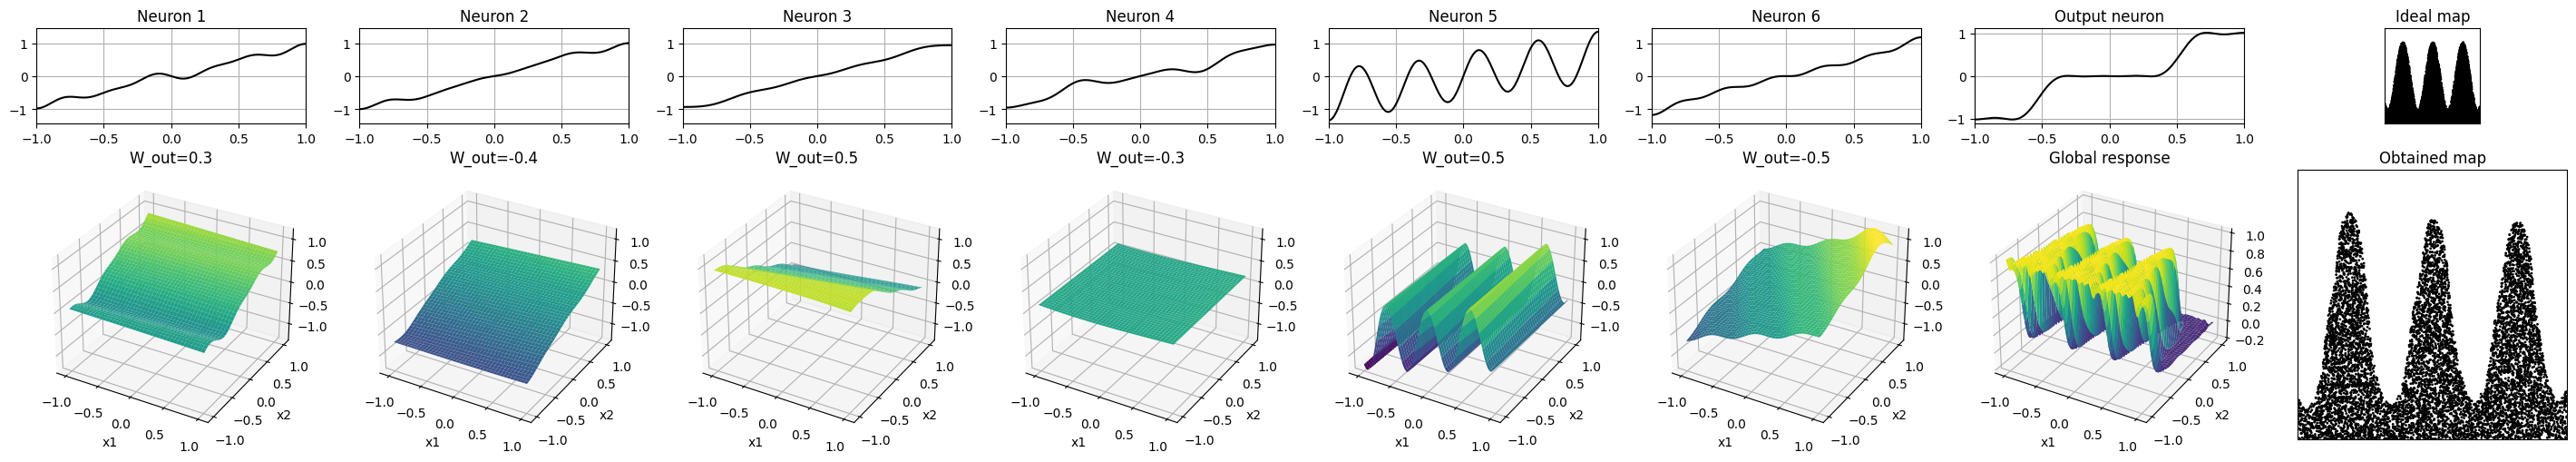

In [ ]:
plot_results(model, test_dataset)

The following example provides interpretable results on the ENN. Notice that  only one neuron is adapted. Particularly, bumps 1 and 2 are identical but with opposite ```W_out```, meaning that they cancel each other. The same happens for neurons 5 and 6. The implication that stems from these results is that the ENN does not need that much expressiveness: it can obtain the desired map with 2 hidden neurons, or even a single one.

Notice that the output activation does not need to approximate a exact step function around the origin because there are no samples with that amplitude. Thus, the center of the output AAF is not adapted.

Iteration: 0. Loss: 0.008077234029769897. Accuracy: 53.0099983215332
Iteration: 1000. Loss: 0.020997226238250732. Accuracy: 90.66500091552734
Iteration: 2000. Loss: 0.001924046315252781. Accuracy: 92.87999725341797
Iteration: 3000. Loss: 1.7362568542012013e-05. Accuracy: 90.70999908447266
Iteration: 4000. Loss: 0.07217252999544144. Accuracy: 94.1050033569336
Iteration: 5000. Loss: 0.0025411653332412243. Accuracy: 88.44000244140625
Iteration: 6000. Loss: 0.0001693569211056456. Accuracy: 88.79499816894531
Iteration: 7000. Loss: 0.003052403684705496. Accuracy: 89.4749984741211
Iteration: 8000. Loss: 0.17529170215129852. Accuracy: 93.50499725341797
Iteration: 9000. Loss: 2.126213257724885e-05. Accuracy: 93.7699966430664
Iteration: 10000. Loss: 0.00046271365135908127. Accuracy: 91.69999694824219
Iteration: 11000. Loss: 0.4947141408920288. Accuracy: 89.88999938964844
Iteration: 12000. Loss: 6.062049214961007e-05. Accuracy: 88.05999755859375
Iteration: 13000. Loss: 0.0002932448696810752. Accu

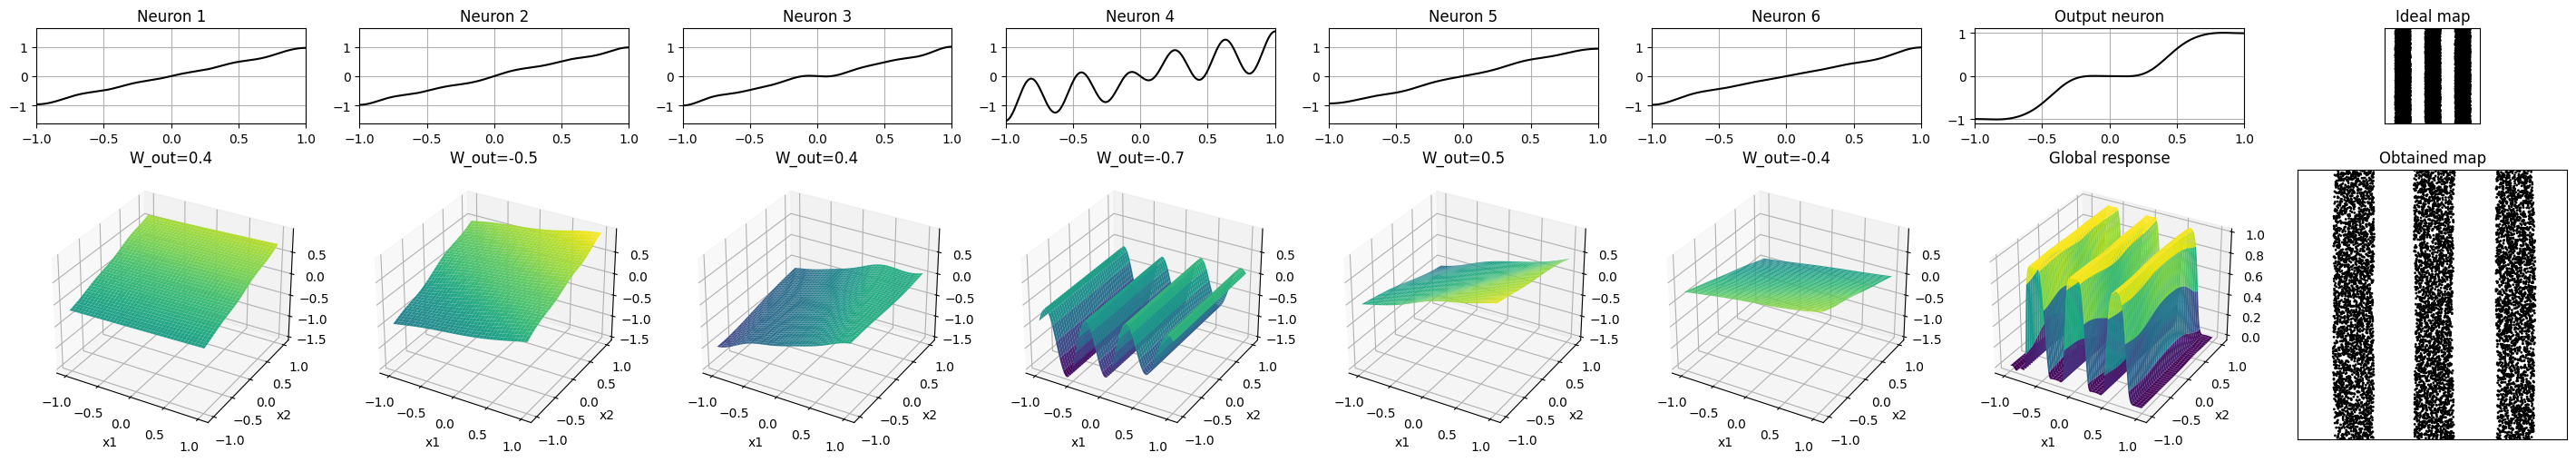

In [23]:
input_dim = 2
hidden_dim = 6
output_dim = 1
init = True
model = ENN(input_dim, hidden_dim, output_dim, init=init)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model.to(device);
num_epochs = 1

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # # Updating parameters
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % (1000/batch_size) == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, labels in test_loader:
                # Forward pass only to get logits/output
                outputs = model(inputs)

                # Get predictions from the maximum value
                predicted = torch.round(outputs)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(i, loss.item(), accuracy))

plot_results(model, test_dataset)